In [1]:
!pip install tensorly
!pip install opencv-python
!pip install --force-reinstall -v "tensorly==0.7.0"
!pip install --force-reinstall -v "numpy==1.23.5"


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Using pip 22.3.1 from C:\Users\nelli\AppData\Local\Programs\Python\Python39\lib\site-packages\pip (python 3.9)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.9.24 which is incompatible.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow 2.9.1 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorflow-gpu 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.9.24 which is incompatible.
tensorflow-gpu 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow-gpu 2.9.1 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 1.24.2 which is incompatible.
flwr 0.19.0 requires numpy<1.21.0,>=1.19.0; python_vers


  Using cached tensorly-0.7.0-py3-none-any.whl (198 kB)
  Using cached numpy-1.24.2-cp39-cp39-win_amd64.whl (14.9 MB)
  Using cached scipy-1.10.1-cp39-cp39-win_amd64.whl (42.5 MB)
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
  Attempting uninstall: nose
    Found existing installation: nose 1.3.7
    Uninstalling nose-1.3.7:
      Removing file or directory c:\users\nelli\appdata\local\programs\python\python39\lib\site-packages\nose-1.3.7.dist-info\
      Removing file or directory c:\users\nelli\appdata\local\programs\python\python39\lib\site-packages\nose\
      Removing file or directory c:\users\nelli\appdata\local\programs\python\python39\man\man1\
      Removing file or directory c:\users\nelli\appdata\local\programs\python\python39\scripts\nosetests-3.4.exe
      Removing file or directory c:\users\nelli\appdata\local\programs\python\python39\scripts\nosetests.exe
      Successfully uninstalled nose-1.3.7
  Attempting uninstall: numpy
    Found existing installation: num

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.9.24 which is incompatible.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow 2.9.1 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorflow-gpu 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.9.24 which is incompatible.
tensorflow-gpu 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow-gpu 2.9.1 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 1.23.5 which is incompatible.
flwr 0.19.0 requires numpy<1.21.0,>=1.19.0; python_vers

In [2]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import scipy.misc
from matplotlib import pyplot as plt
from glob import glob
from random import shuffle
import tensorly as tl
from tensorly.decomposition import tucker, partial_tucker
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
import warnings
warnings.filterwarnings('ignore')

In [3]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())


def preprocess(image):
    core, factors = partial_tucker(tl.tensor(image), rank=image.shape, modes=[0, 1, 2])
    gray = normalize(factors[0])
    return gray


def get_patches(image, patch_size=4):    
    patches = extract_patches_2d(image, (patch_size, patch_size))
    return patches


def get_matrix(y, image_path, patch_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = preprocess(image)
    size = gray.shape[0]
    patches = get_patches(gray, patch_size)
    data = patches.reshape(patches.shape[0], -1)
    y = np.vstack([y, data])
    y = np.delete(y, 0, axis=0)
    return y


def get_features(x):
    f_mic = []
    f_mac = []
    for i in range(x.shape[0]):
        values = x[i]
        values = np.abs(values[values!=0])
        sigma, _, mean = sp.stats.lognorm.fit(values, loc=0)
        f_mic.append(np.exp(mean + 0.5*sigma**2))
        f_mac.append(values.shape[0])
    return f_mic + f_mac

In [4]:
class KSVD(object):


    def __init__(self, n_components, max_iter=30, tol=1e-6, n_nonzero_coefs=None):
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs


    def initialize(self, y):
        u, s, v = np.linalg.svd(y)
        self.dictionary = u[:, :self.n_components]

        
    def update_dictionary(self, y, d, x):
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue
            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        return d, x

    
    def fit(self, y):
        self.initialize(y)
        for i in range(self.max_iter):
            print("Iter №:", i)
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
            e = np.linalg.norm(y - np.dot(self.dictionary, x))
            if e < self.tol:
                break
            self.update_dictionary(y, self.dictionary, x)
        self.sparsecode = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)
        return self.dictionary, self.sparsecode

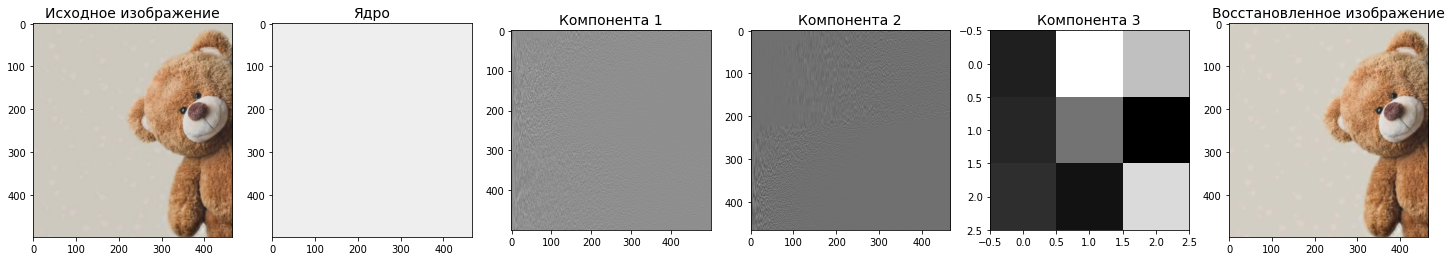

In [5]:
image_path = 'test.jpg'
image = cv2.imread(image_path) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
core, factors = partial_tucker(tl.tensor(image), rank=image.shape, modes=[0, 1, 2])
image_3 = tl.tucker_to_tensor((core, factors))
gray = normalize(factors[0]) 

plt.figure(figsize=(25,10))
plt.subplot(1, 6, 1)
plt.title('Исходное изображение', fontsize=14)
plt.imshow(image)
plt.subplot(1, 6, 2)
plt.title('Ядро', fontsize=14)
plt.imshow(normalize(core), cmap='gray')
plt.subplot(1, 6, 3)
plt.title('Компонента 1', fontsize=14)
plt.imshow(normalize(factors[0]), cmap='gray')
plt.subplot(1, 6, 4)
plt.title('Компонента 2', fontsize=14)
plt.imshow(normalize(factors[1]), cmap='gray')
plt.subplot(1, 6, 5)
plt.title('Компонента 3', fontsize=14)
plt.imshow(normalize(factors[2]), cmap='gray')
plt.subplot(1, 6, 6)
plt.title('Восстановленное изображение', fontsize=14)
plt.imshow(normalize(image_3), cmap='gray')
plt.show()

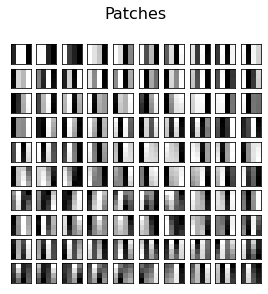

In [6]:
size = gray.shape[0]
patch_size = 4
patches = get_patches(gray, patch_size)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(patches[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((patch_size, patch_size)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Patches\n",
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Iter №: 0
Размер матрицы с изображениями:  (16, 15601)
Размер матрицы-словаря:          (16, 16)
Размер матрицы коэффициентов:    (16, 15601)
Точность восстановления:         5.632e-14



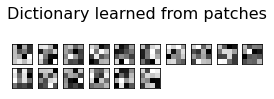

In [7]:
patch_size = 4
p = patch_size * patch_size
k = p
image_directory = 'images/images_28/'
image_paths = glob(os.path.join(image_directory, '*.png'))
shuffle(image_paths)
image_paths = image_paths[:25]
y = np.zeros(p)
for image_path in image_paths:
    y = get_matrix(y, image_path, patch_size)
y = y.T
ksvd = KSVD(y.shape[1], max_iter=5, tol=0.1, n_nonzero_coefs=k)
D, x = ksvd.fit(y)
e = np.linalg.norm(y - np.dot(D, x))
np.save(open('dictionary.npy', 'wb'), D)
print('Размер матрицы с изображениями: ', y.shape)
print('Размер матрицы-словаря:         ', D.shape)
print('Размер матрицы коэффициентов:   ', x.shape)
print('Точность восстановления:         %.3e' % e)
print()

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(D[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((patch_size, patch_size)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from patches\n",
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [ ]:
df = pd.read_csv('images/response.csv')
images = df['image'].tolist()
labels = df['label'].tolist()
image_paths = ['images/images_28/'+image for image in images]
del df

columns = ['image']
for i in range(D.shape[1]):
    columns.append('f%d_mic'%(i+1))
for i in range(D.shape[1]):
    columns.append('f%d_mac'%(i+1))
columns.append('label')

data = {column: [] for column in columns}
df = pd.DataFrame(data)

for i, image_path in enumerate(image_paths):
    try:
        y = np.zeros(p)
        y = get_matrix(y, image_path, patch_size)
        y = y.T
        X = linear_model.orthogonal_mp(D, y, n_nonzero_coefs=p)
        features = get_features(X)
        data = [images[i]] + features + [labels[i]]
        data = {column: [datum] for column, datum in zip(columns, data)}
        tmp = pd.DataFrame(data)
        df = pd.concat([df, tmp], axis=0)
        print('%d/%d %s' % (i, len(image_paths), image_path))
    except:
        continue

df.to_csv('_dataset.csv', index=False)

0/4262 images/images_28/image1.png
1/4262 images/images_28/image2.png
2/4262 images/images_28/image3.png
3/4262 images/images_28/image4.png
4/4262 images/images_28/image5.png
5/4262 images/images_28/image6.png
6/4262 images/images_28/image7.png
7/4262 images/images_28/image8.png
8/4262 images/images_28/image9.png
9/4262 images/images_28/image10.png
10/4262 images/images_28/image11.png
11/4262 images/images_28/image12.png
12/4262 images/images_28/image13.png
13/4262 images/images_28/image14.png
14/4262 images/images_28/image15.png
15/4262 images/images_28/image16.png
16/4262 images/images_28/image17.png
17/4262 images/images_28/image18.png
18/4262 images/images_28/image19.png
19/4262 images/images_28/image20.png
20/4262 images/images_28/image21.png
21/4262 images/images_28/image22.png
22/4262 images/images_28/image23.png
23/4262 images/images_28/image24.png
24/4262 images/images_28/image25.png
25/4262 images/images_28/image26.png
26/4262 images/images_28/image27.png
27/4262 images/image

216/4262 images/images_28/image217.png
217/4262 images/images_28/image218.png
218/4262 images/images_28/image219.png
219/4262 images/images_28/image220.png
220/4262 images/images_28/image221.png
221/4262 images/images_28/image222.png
222/4262 images/images_28/image223.png
223/4262 images/images_28/image224.png
224/4262 images/images_28/image225.png
225/4262 images/images_28/image226.png
226/4262 images/images_28/image227.png
227/4262 images/images_28/image228.png
228/4262 images/images_28/image229.png
229/4262 images/images_28/image230.png
230/4262 images/images_28/image231.png
231/4262 images/images_28/image232.png
232/4262 images/images_28/image233.png
233/4262 images/images_28/image234.png
234/4262 images/images_28/image235.png
235/4262 images/images_28/image236.png
236/4262 images/images_28/image237.png
237/4262 images/images_28/image238.png
238/4262 images/images_28/image239.png
239/4262 images/images_28/image240.png
240/4262 images/images_28/image241.png
241/4262 images/images_28

427/4262 images/images_28/image428.png
428/4262 images/images_28/image429.png
429/4262 images/images_28/image430.png
430/4262 images/images_28/image431.png
431/4262 images/images_28/image432.png
432/4262 images/images_28/image433.png
433/4262 images/images_28/image434.png
434/4262 images/images_28/image435.png
435/4262 images/images_28/image436.png
436/4262 images/images_28/image437.png
437/4262 images/images_28/image438.png
438/4262 images/images_28/image439.png
439/4262 images/images_28/image440.png
440/4262 images/images_28/image441.png
441/4262 images/images_28/image442.png
442/4262 images/images_28/image443.png
443/4262 images/images_28/image444.png
444/4262 images/images_28/image445.png
445/4262 images/images_28/image446.png
446/4262 images/images_28/image447.png
447/4262 images/images_28/image448.png
448/4262 images/images_28/image449.png
449/4262 images/images_28/image450.png
450/4262 images/images_28/image451.png
451/4262 images/images_28/image452.png
452/4262 images/images_28

638/4262 images/images_28/image639.png
639/4262 images/images_28/image640.png
640/4262 images/images_28/image641.png
641/4262 images/images_28/image642.png
642/4262 images/images_28/image643.png
643/4262 images/images_28/image644.png
644/4262 images/images_28/image645.png
645/4262 images/images_28/image646.png
646/4262 images/images_28/image647.png
647/4262 images/images_28/image648.png
648/4262 images/images_28/image649.png
649/4262 images/images_28/image650.png
650/4262 images/images_28/image651.png
651/4262 images/images_28/image652.png
652/4262 images/images_28/image653.png
653/4262 images/images_28/image654.png
654/4262 images/images_28/image655.png
655/4262 images/images_28/image656.png
656/4262 images/images_28/image657.png
657/4262 images/images_28/image658.png
658/4262 images/images_28/image659.png
659/4262 images/images_28/image660.png
660/4262 images/images_28/image661.png
661/4262 images/images_28/image662.png
662/4262 images/images_28/image663.png
663/4262 images/images_28

849/4262 images/images_28/image850.png
850/4262 images/images_28/image851.png
851/4262 images/images_28/image852.png
852/4262 images/images_28/image853.png
853/4262 images/images_28/image854.png
854/4262 images/images_28/image855.png
855/4262 images/images_28/image856.png
856/4262 images/images_28/image857.png
857/4262 images/images_28/image858.png
858/4262 images/images_28/image859.png
859/4262 images/images_28/image860.png
860/4262 images/images_28/image861.png
861/4262 images/images_28/image862.png
862/4262 images/images_28/image863.png
863/4262 images/images_28/image864.png
864/4262 images/images_28/image865.png
865/4262 images/images_28/image866.png
866/4262 images/images_28/image867.png
867/4262 images/images_28/image868.png
868/4262 images/images_28/image869.png
869/4262 images/images_28/image870.png
870/4262 images/images_28/image871.png
871/4262 images/images_28/image872.png
872/4262 images/images_28/image873.png
873/4262 images/images_28/image874.png
874/4262 images/images_28

1057/4262 images/images_28/image1058.png
1058/4262 images/images_28/image1059.png
1059/4262 images/images_28/image1060.png
1060/4262 images/images_28/image1061.png
1061/4262 images/images_28/image1062.png
1062/4262 images/images_28/image1063.png
1063/4262 images/images_28/image1064.png
1064/4262 images/images_28/image1065.png
1065/4262 images/images_28/image1066.png
1066/4262 images/images_28/image1067.png
1067/4262 images/images_28/image1068.png
1068/4262 images/images_28/image1069.png
1069/4262 images/images_28/image1070.png
1070/4262 images/images_28/image1071.png
1071/4262 images/images_28/image1072.png
1072/4262 images/images_28/image1073.png
1073/4262 images/images_28/image1074.png
1074/4262 images/images_28/image1075.png
1075/4262 images/images_28/image1076.png
1076/4262 images/images_28/image1077.png
1077/4262 images/images_28/image1078.png
1078/4262 images/images_28/image1079.png
1079/4262 images/images_28/image1080.png
1080/4262 images/images_28/image1081.png
1081/4262 images

1257/4262 images/images_28/image1258.png
1258/4262 images/images_28/image1259.png
1259/4262 images/images_28/image1260.png
1260/4262 images/images_28/image1261.png
1261/4262 images/images_28/image1262.png
1262/4262 images/images_28/image1263.png
1263/4262 images/images_28/image1264.png
1264/4262 images/images_28/image1265.png
1265/4262 images/images_28/image1266.png
1266/4262 images/images_28/image1267.png
1267/4262 images/images_28/image1268.png
1268/4262 images/images_28/image1269.png
1269/4262 images/images_28/image1270.png
1270/4262 images/images_28/image1271.png
1271/4262 images/images_28/image1272.png
1272/4262 images/images_28/image1273.png
1273/4262 images/images_28/image1274.png
1274/4262 images/images_28/image1275.png
1275/4262 images/images_28/image1276.png
1276/4262 images/images_28/image1277.png
1277/4262 images/images_28/image1278.png
1278/4262 images/images_28/image1279.png
1279/4262 images/images_28/image1280.png
1280/4262 images/images_28/image1281.png
1281/4262 images

1457/4262 images/images_28/image1458.png
1458/4262 images/images_28/image1459.png
1459/4262 images/images_28/image1460.png
1460/4262 images/images_28/image1461.png
1461/4262 images/images_28/image1462.png
1462/4262 images/images_28/image1463.png
1463/4262 images/images_28/image1464.png
1464/4262 images/images_28/image1465.png
1465/4262 images/images_28/image1466.png
1466/4262 images/images_28/image1467.png
1467/4262 images/images_28/image1468.png
1468/4262 images/images_28/image1469.png
1469/4262 images/images_28/image1470.png
1470/4262 images/images_28/image1471.png
1471/4262 images/images_28/image1472.png
1472/4262 images/images_28/image1473.png
1473/4262 images/images_28/image1474.png
1474/4262 images/images_28/image1475.png
1475/4262 images/images_28/image1476.png
1476/4262 images/images_28/image1477.png
1477/4262 images/images_28/image1478.png
1478/4262 images/images_28/image1479.png
1479/4262 images/images_28/image1480.png
1480/4262 images/images_28/image1481.png
1481/4262 images

1657/4262 images/images_28/image1658.png
1658/4262 images/images_28/image1659.png
1659/4262 images/images_28/image1660.png
1660/4262 images/images_28/image1661.png
1661/4262 images/images_28/image1662.png
1662/4262 images/images_28/image1663.png
1663/4262 images/images_28/image1664.png
1664/4262 images/images_28/image1665.png
1665/4262 images/images_28/image1666.png
1666/4262 images/images_28/image1667.png
1667/4262 images/images_28/image1668.png
1668/4262 images/images_28/image1669.png
1669/4262 images/images_28/image1670.png
1670/4262 images/images_28/image1671.png
1671/4262 images/images_28/image1672.png
1672/4262 images/images_28/image1673.png
1673/4262 images/images_28/image1674.png
1674/4262 images/images_28/image1675.png
1675/4262 images/images_28/image1676.png
1676/4262 images/images_28/image1677.png
1677/4262 images/images_28/image1678.png
1678/4262 images/images_28/image1679.png
1679/4262 images/images_28/image1680.png
1680/4262 images/images_28/image1681.png
1681/4262 images

1857/4262 images/images_28/image1858.png
1858/4262 images/images_28/image1859.png
1859/4262 images/images_28/image1860.png
1860/4262 images/images_28/image1861.png
1861/4262 images/images_28/image1862.png
1862/4262 images/images_28/image1863.png
1863/4262 images/images_28/image1864.png
1864/4262 images/images_28/image1865.png
1865/4262 images/images_28/image1866.png
1866/4262 images/images_28/image1867.png
1867/4262 images/images_28/image1868.png
1868/4262 images/images_28/image1869.png
1869/4262 images/images_28/image1870.png
1870/4262 images/images_28/image1871.png
1871/4262 images/images_28/image1872.png
1872/4262 images/images_28/image1873.png
1873/4262 images/images_28/image1874.png
1874/4262 images/images_28/image1875.png
1875/4262 images/images_28/image1876.png
1876/4262 images/images_28/image1877.png
1877/4262 images/images_28/image1878.png
1878/4262 images/images_28/image1879.png
1879/4262 images/images_28/image1880.png
1880/4262 images/images_28/image1881.png
1881/4262 images

2057/4262 images/images_28/image2058.png
2058/4262 images/images_28/image2059.png
2059/4262 images/images_28/image2060.png
2060/4262 images/images_28/image2061.png
2061/4262 images/images_28/image2062.png
2062/4262 images/images_28/image2063.png
2063/4262 images/images_28/image2064.png
2064/4262 images/images_28/image2065.png
2065/4262 images/images_28/image2066.png
2066/4262 images/images_28/image2067.png
2067/4262 images/images_28/image2068.png
2068/4262 images/images_28/image2069.png
2069/4262 images/images_28/image2070.png
2070/4262 images/images_28/image2071.png
2071/4262 images/images_28/image2072.png
2072/4262 images/images_28/image2073.png
2073/4262 images/images_28/image2074.png
2074/4262 images/images_28/image2075.png
2075/4262 images/images_28/image2076.png
2076/4262 images/images_28/image2077.png
2077/4262 images/images_28/image2078.png
2078/4262 images/images_28/image2079.png
2079/4262 images/images_28/image2080.png
2080/4262 images/images_28/image2081.png
2081/4262 images

2257/4262 images/images_28/image2258.png
2258/4262 images/images_28/image2259.png
2259/4262 images/images_28/image2260.png
2260/4262 images/images_28/image2261.png
2261/4262 images/images_28/image2262.png
2262/4262 images/images_28/image2263.png
2263/4262 images/images_28/image2264.png
2264/4262 images/images_28/image2265.png
2265/4262 images/images_28/image2266.png
2266/4262 images/images_28/image2267.png
2267/4262 images/images_28/image2268.png
2268/4262 images/images_28/image2269.png
2269/4262 images/images_28/image2270.png
2270/4262 images/images_28/image2271.png
2271/4262 images/images_28/image2272.png
2272/4262 images/images_28/image2273.png
2273/4262 images/images_28/image2274.png
2274/4262 images/images_28/image2275.png
2275/4262 images/images_28/image2276.png
2276/4262 images/images_28/image2277.png
2277/4262 images/images_28/image2278.png
2278/4262 images/images_28/image2279.png
2279/4262 images/images_28/image2280.png
2280/4262 images/images_28/image2281.png
2281/4262 images

2457/4262 images/images_28/image2458.png
2458/4262 images/images_28/image2459.png
2459/4262 images/images_28/image2460.png
2460/4262 images/images_28/image2461.png
2461/4262 images/images_28/image2462.png
2462/4262 images/images_28/image2463.png
2463/4262 images/images_28/image2464.png
2464/4262 images/images_28/image2465.png
2465/4262 images/images_28/image2466.png
2466/4262 images/images_28/image2467.png
2467/4262 images/images_28/image2468.png
2468/4262 images/images_28/image2469.png
2469/4262 images/images_28/image2470.png
2470/4262 images/images_28/image2471.png
2471/4262 images/images_28/image2472.png
2472/4262 images/images_28/image2473.png
2473/4262 images/images_28/image2474.png
2474/4262 images/images_28/image2475.png
2475/4262 images/images_28/image2476.png
2476/4262 images/images_28/image2477.png
2477/4262 images/images_28/image2478.png
2478/4262 images/images_28/image2479.png
2479/4262 images/images_28/image2480.png
2480/4262 images/images_28/image2481.png
2481/4262 images

2657/4262 images/images_28/image2658.png
2658/4262 images/images_28/image2659.png
2659/4262 images/images_28/image2660.png
2660/4262 images/images_28/image2661.png
2661/4262 images/images_28/image2662.png
2662/4262 images/images_28/image2663.png
2663/4262 images/images_28/image2664.png
2664/4262 images/images_28/image2665.png
2665/4262 images/images_28/image2666.png
2666/4262 images/images_28/image2667.png
2667/4262 images/images_28/image2668.png
2668/4262 images/images_28/image2669.png
2669/4262 images/images_28/image2670.png
2670/4262 images/images_28/image2671.png
2671/4262 images/images_28/image2672.png
2672/4262 images/images_28/image2673.png
2673/4262 images/images_28/image2674.png
2674/4262 images/images_28/image2675.png
2675/4262 images/images_28/image2676.png
2676/4262 images/images_28/image2677.png
2677/4262 images/images_28/image2678.png
2678/4262 images/images_28/image2679.png
2679/4262 images/images_28/image2680.png
2680/4262 images/images_28/image2681.png
2681/4262 images

2857/4262 images/images_28/image2858.png
2858/4262 images/images_28/image2859.png
2859/4262 images/images_28/image2860.png
2860/4262 images/images_28/image2861.png
2861/4262 images/images_28/image2862.png
2862/4262 images/images_28/image2863.png
2863/4262 images/images_28/image2864.png
2864/4262 images/images_28/image2865.png
2865/4262 images/images_28/image2866.png
2866/4262 images/images_28/image2867.png
2867/4262 images/images_28/image2868.png
2868/4262 images/images_28/image2869.png
2869/4262 images/images_28/image2870.png
2870/4262 images/images_28/image2871.png
2871/4262 images/images_28/image2872.png
2872/4262 images/images_28/image2873.png
2873/4262 images/images_28/image2874.png
2874/4262 images/images_28/image2875.png
2875/4262 images/images_28/image2876.png
2876/4262 images/images_28/image2877.png
2877/4262 images/images_28/image2878.png
2878/4262 images/images_28/image2879.png
2879/4262 images/images_28/image2880.png
2880/4262 images/images_28/image2881.png
2881/4262 images

3057/4262 images/images_28/image3058.png
3058/4262 images/images_28/image3059.png


In [ ]:
df = pd.read_csv('_dataset.csv')
columns = [column for column in df.columns if column not in ['image', 'label']]
x = df[columns].to_numpy()
y = df['label'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)
model = make_pipeline(StandardScaler(), SVR(C=25, epsilon=0.3, gamma=0.9))
model.fit(x_train, y_train)
y_pred = model.predict(x_test)